# Bayesian random effects meta-analyses
---

**Table of contents:**

- [Meta-analysis of two proportions in random control trials (RCTs)](#Meta-analysis-of-two-proportions-in-random-control-trials)
- [Random effects meta-analysis with normally distributed outcomes (Beta)](#Random-effects-meta-analysis-with-normally-distributed-outcomes-(Beta))

## Meta-analysis of two proportions in random control trials

This notebook shows how to perform a specific type of meta-analysis in Python/PyMC. The example is adapted from John Kruschke, who originally implemented this analysis in R. Here are links to his [blog entry](http://doingbayesiandataanalysis.blogspot.com/2016/11/bayesian-meta-analysis-of-two.html) and [article](https://link.springer.com/article/10.3758/s13423-016-1221-4).

In this example, we are interested in the number of deaths ("occurrences of mortality") from heart attack in a control group and a treatment group that were "treated" with beta-blockers (a class of drugs that relaxes heart muscles). Let $z_T$ denote the number of occurrences in the treatment group, $n_T$ denote the total number of participants in the treatment group, and $z_C$ and $n_C$ denote the same for the controls. If beta-blockers have a beneficial effect, then $z_T/n_T$ should be less than $z_C/n_C$. 

In a meta-analysis, we are combining information (data) from several studies examining the same phenomenon in order to make better inferences. The data from study $s$ are denoted $z_{C[s]}$, $n_{C[s]}$, etc. The key insight is that even though we don't expect the proportions of occurrences to be identical across different studies/sites, as each site has its own attributes, we do expect the studies to be similar and mutually informative. That is, we expect Study A to tell us something about Study B, and vice versa. This means we should treat the data from different sites as representative of higher-level parameters that describe what is typical across sites and how much variability there is across sites. This approach is referred to as a **random-effects model**. Here are the equations for this model, starting with the likelihoods in the first two lines:

$$z_C \sim \text{Binomial}(\theta_{C[s]}, n_{C[s]})$$
$$z_T \sim \text{Binomial}(\theta_{T[s]}, n_{T[s]})$$
$$\theta_{C[s]} \sim \text{Beta}(\omega_{\theta C})$$
$$\theta_{T[s]} = \text{logistic}(\rho_s + \text{logit}(\theta_{C[s]}))$$
$$\rho_{s} \sim \text{Normal}(\mu_{\rho}, \sigma_{\rho}^2)$$
$$\mu_{\rho} \sim \text{Normal}(0, 10)$$
$$\sigma_{\rho} \sim \text{Gamma}(\alpha=1.64, \beta=0.64)$$

Here, $\rho_s$ is the difference of log-odds between groups, or, the *log odds ratio* across groups: $\rho_s = \text{log}([\theta_{T[s]}/(1 - \theta_{T[s]})]/[\theta_{C[s]}/(1 - \theta_{C[s]})]$. The distribution across $\rho_s$ is described by a normal distribution, parameterized by its mean and SD. Therefore, what we are most interested in is $\mu_{\rho}$, the estimated treatement effect across studies. ***Check out the links I've provided at the top for more details.*** 

The data we will model are from 22 studies, involving anywhere between 77 and 3,887 patients. They are described in Gelman et al.'s *Bayesian Data Analysis, Third Edition*. The treatment group received beta-blockers. If the treatment is effective, the log odds ratio will be less than zero. 

In [1]:
import arviz as az
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import matplotlib.pyplot as plt

# Import meta-analysis module of bayes-toolbox
import bayes_toolbox.meta as bm

In [2]:
%config InlineBackend.figure_format = 'retina'
# az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.95
rng = np.random.default_rng(seed=46)

In [3]:
# Data from 22 studies
# fmt: off
z_t_obs = [
    3, 7, 5, 102, 28, 4, 98, 60, 25, 138, 64, 45, 9, 57, 25, 33, 28, 8, 6, 32, 27, 22
]
n_t_obs = [
    38, 114, 69, 1533, 355, 59, 945, 632, 278,1916, 873, 263, 291, 858, 154, 207, 251,
    151, 174, 209, 391, 680
]
z_c_obs = [
    3, 14, 11, 127, 27, 6, 152, 48, 37, 188, 52, 47, 16, 45, 31, 38, 12, 6, 3, 40, 43,
    39
]
n_c_obs = [
    39, 116, 93, 1520, 365, 52, 939, 471, 282, 1921, 583, 266, 293, 883, 147, 213, 122, 
    154, 134, 218, 364, 674
]
# fmt: on

# We will "name" each study to provide study labels to parameters in our summary plots
N = len(n_c_obs)
study = []
for x in range(N):
    study.append("study" + str(x + 1))

# Create dataframe
df = pd.DataFrame(
    {
        "z_t_obs": z_t_obs,
        "n_t_obs": n_t_obs,
        "z_c_obs": z_c_obs,
        "n_c_obs": n_c_obs,
        "study": study,
    }
)

In [4]:
# Call your bayes-toolbox function and fit model
model, idata = bm.meta_binary_outcome(
    z_t_obs, n_t_obs, z_c_obs, n_c_obs, study, n_draws=2000
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_rho, sigma_rho, omega_theta_c, kappa_minus_two_theta_c, rho, theta_c]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 44 seconds.


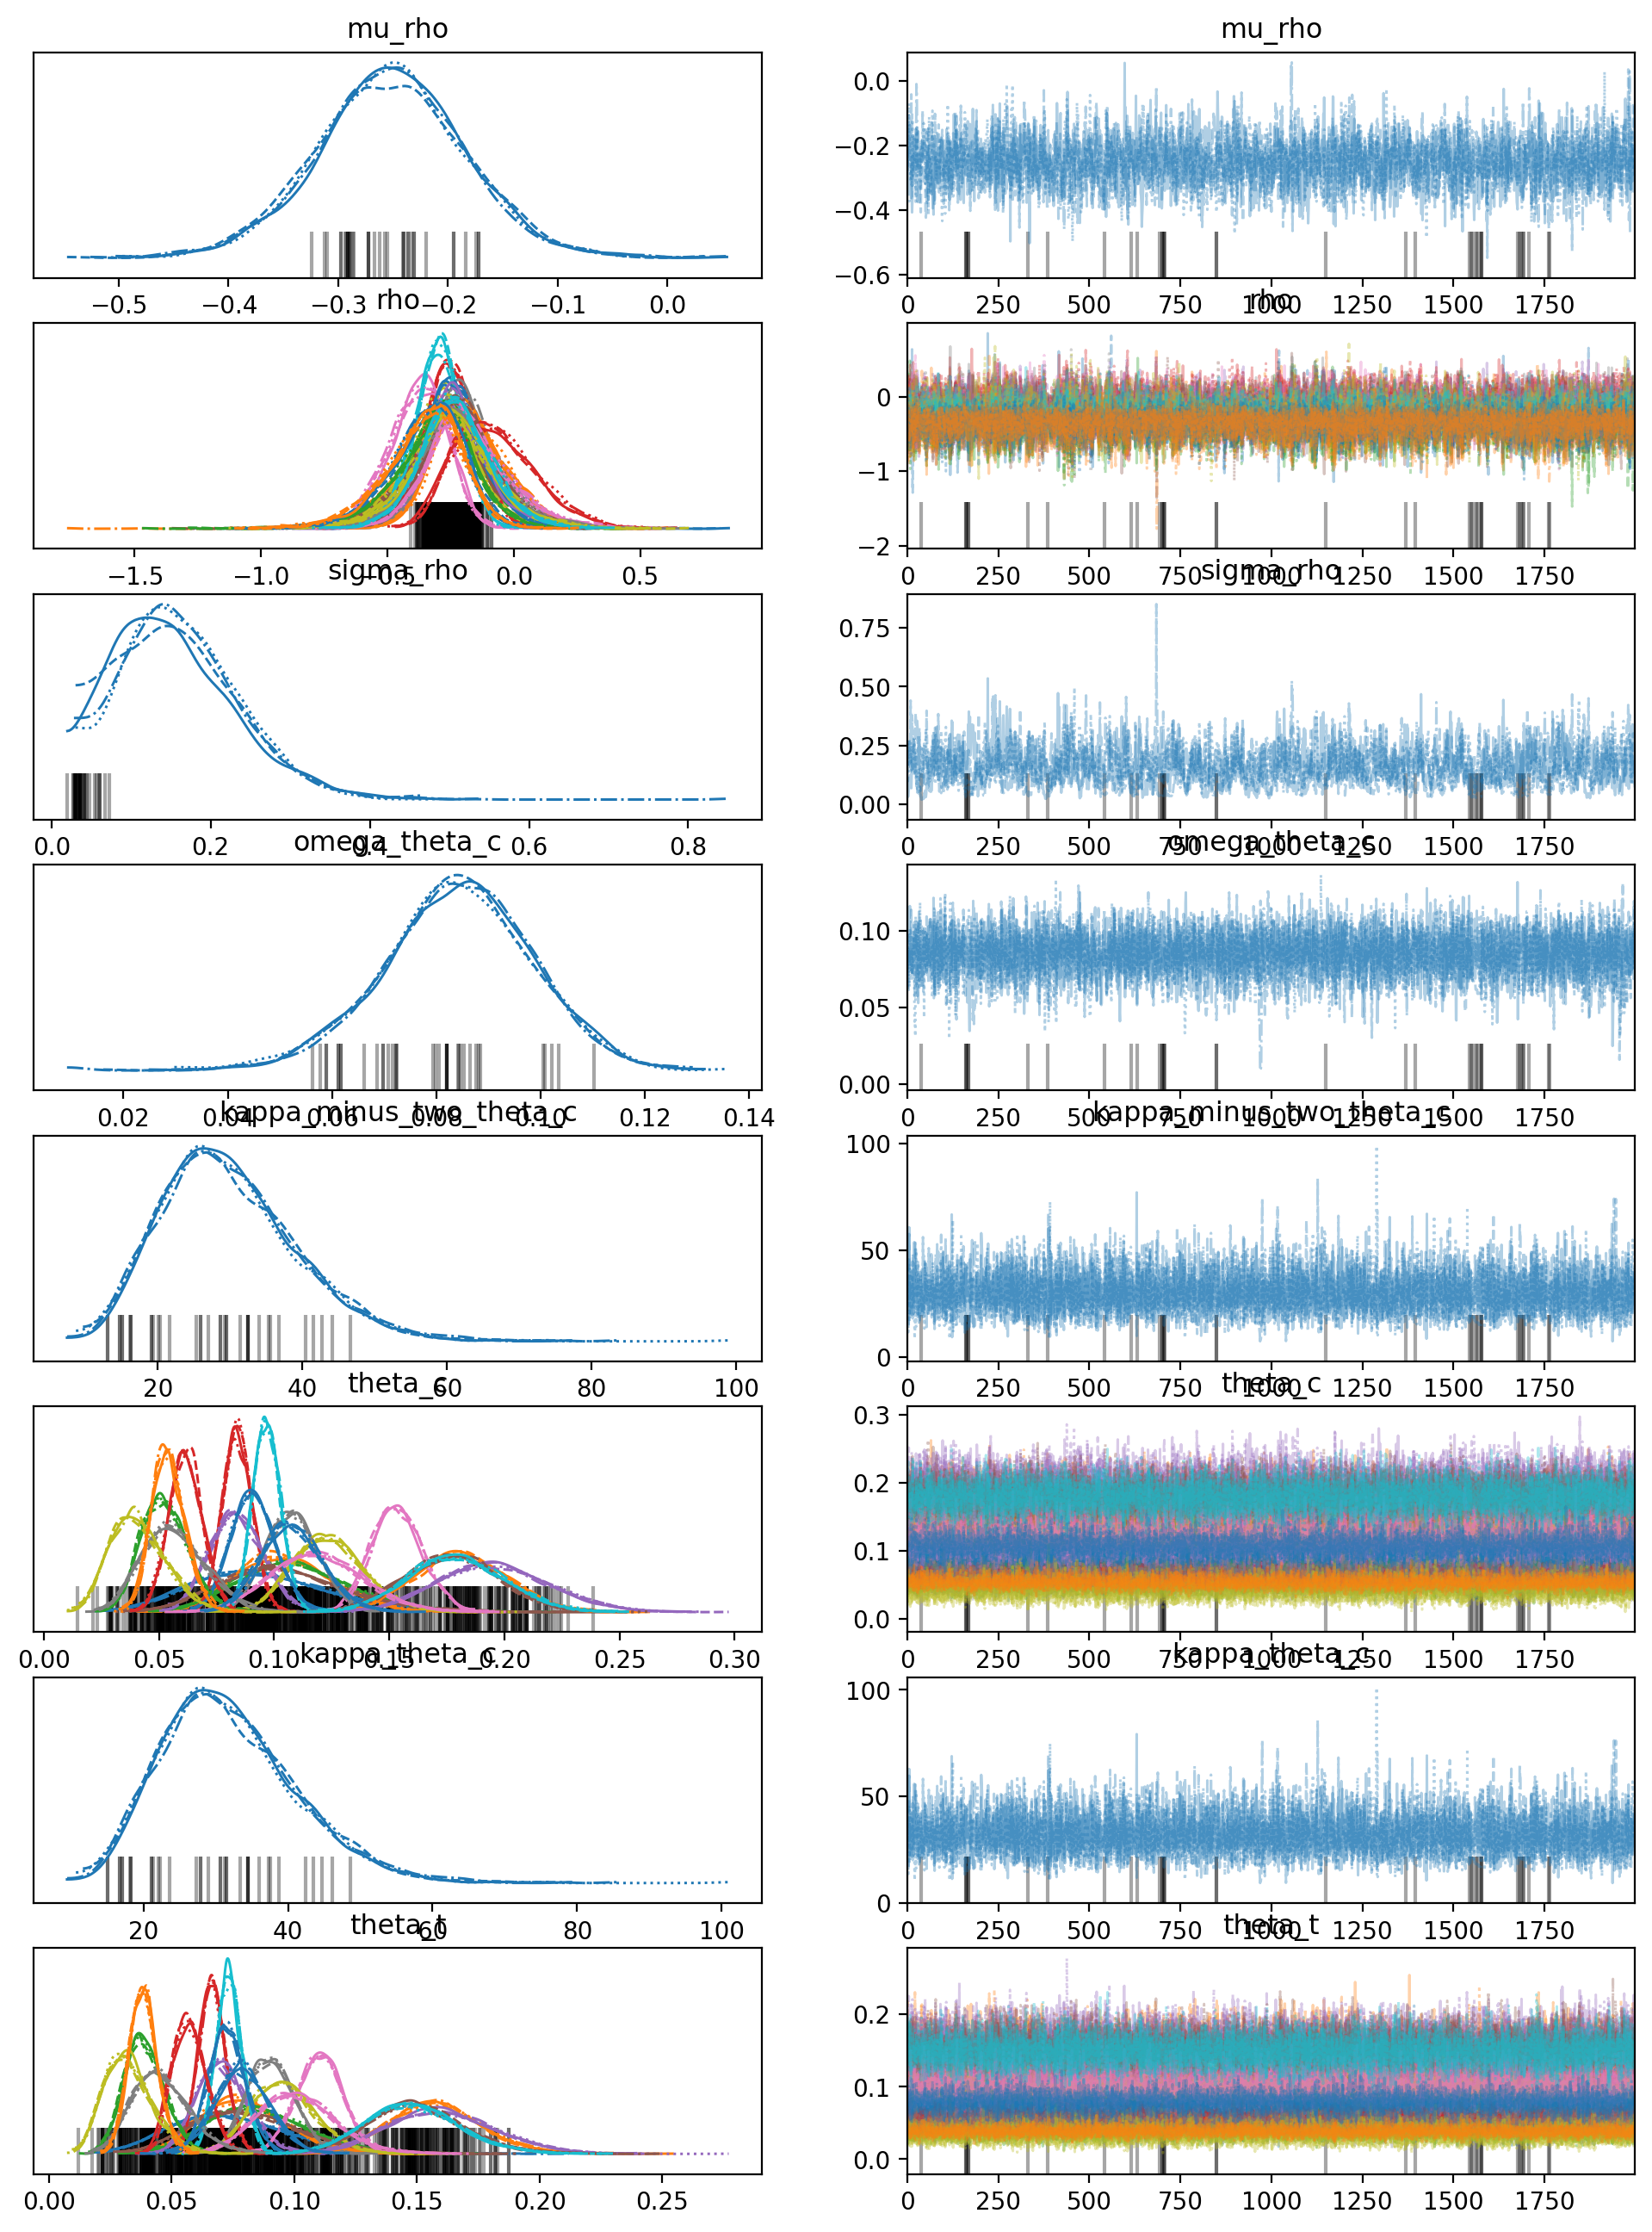

In [5]:
# Check the health of your MCMC chains
az.plot_trace(idata);

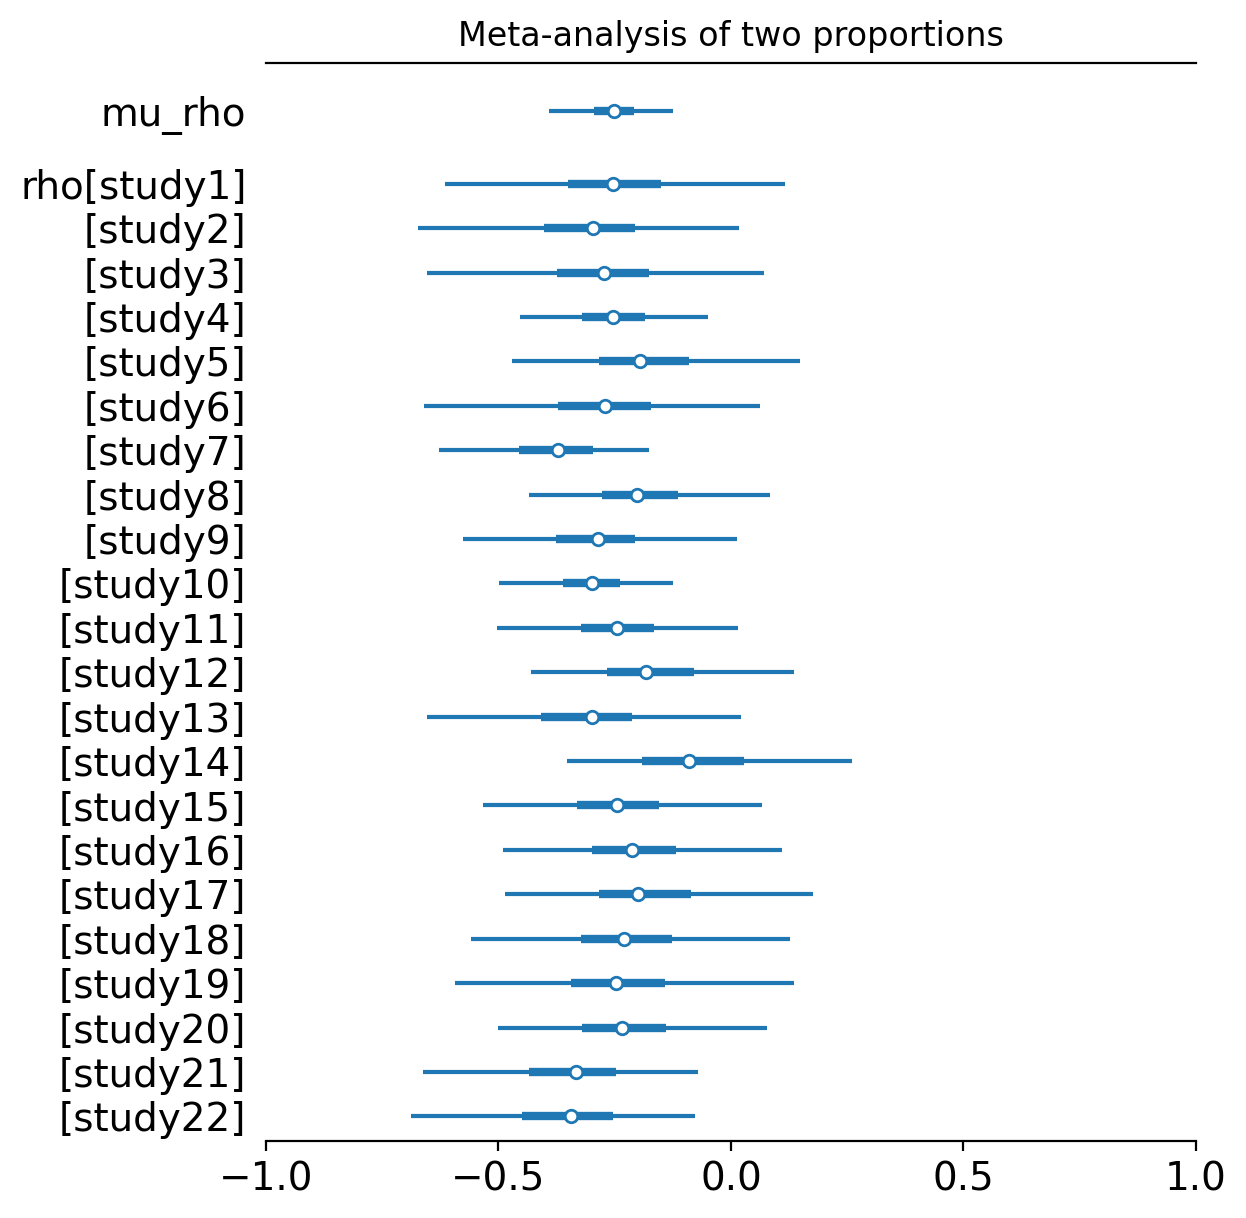

In [6]:
# Forest plot
_, ax = plt.subplots(figsize=(6, 7))
az.plot_forest(
    idata, var_names=["mu_rho", "rho"], kind="forestplot", combined=True, ax=ax
)
ax.set_xlim([-1, 1])
ax.set_title("Meta-analysis of two proportions");

In [7]:
# Plot parameter estimates
az.summary(idata, var_names=["mu_rho", "rho"])

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_rho,-0.252,0.068,-0.391,-0.124,0.001,0.001,2550.0,4155.0,1.0
rho[study1],-0.251,0.179,-0.615,0.117,0.002,0.002,6611.0,4534.0,1.0
rho[study2],-0.310,0.170,-0.673,0.018,0.002,0.002,5252.0,3894.0,1.0
rho[study3],-0.277,0.173,-0.655,0.072,0.002,0.002,5730.0,4391.0,1.0
rho[study4],-0.253,0.104,-0.455,-0.049,0.001,0.001,5356.0,5600.0,1.0
rho[study5],-0.181,0.154,-0.471,0.148,0.003,0.002,3689.0,4316.0,1.0
rho[study6],-0.277,0.176,-0.661,0.063,0.002,0.002,6263.0,4673.0,1.0
rho[study7],-0.381,0.117,-0.627,-0.175,0.003,0.002,1766.0,4524.0,1.0
rho[study8],-0.193,0.130,-0.433,0.083,0.002,0.001,3931.0,4398.0,1.0
rho[study9],-0.294,0.144,-0.576,0.014,0.002,0.002,5123.0,4391.0,1.0


The estimated parameter values above are highly consistent with those reported in the Kruschke analysis using R and JAGS.

## Random effects meta-analysis with normally distributed outcomes (Beta)
---

Now, we will consider the situation where instead of binary outcomes from a study, we are looking at normally distributed effects. Let's pretend the data below come from 19 different studies examining the effect of a rare genetic disorder on movement control, where the main outcome variable is endpoint accuracy. We have the reported standardized effect sizes (e.g., Cohen's d) quantifying the difference in performance measures between the patient group and age-matched controls as well as the reported standard errors of the effect size. 

In [8]:
# Data
# fmt: off
eff_size = np.array([0.334647179, -0.2997250305, -0.2428621299, -1.622743498, 
                     -0.2423718801, -1.06431894, 0.2937822071, -1.499113213, -0.8203,
                     -0.5974, -0.1137870633, 0.1822088181, -0.0935022265, -0.775408451,
                     -0.1736013005, -0.3385696316, -1.024715091, -0.08220616002, 
                     0.1098119513])
se_eff_size = np.array([0.450357143, 0.449693878, 0.587653061, 0.672704082, 0.461173469, 
                        0.477806122, 0.588571429, 0.660663265, 0.54372449, 1.1338, 0.507908163, 
                        0.354285714, 0.39244898, 0.445714286, 0.37867347, 0.3980102, 0.40923469, 
                        0.527244898, 0.816938776])
# fmt: on

# We will "name" each study to provide study labels to parameters in our summary plots
N = len(eff_size)
study = []
for x in range(N):
    study.append("study" + str(x + 1))

# Create dataframe
df = pd.DataFrame({"eff_size": eff_size, "se_eff_size": se_eff_size, "study": study})

In [9]:
model_normal, idata_normal = bm.meta_normal_outcome_beta_version(
    eff_size, se_eff_size, study, n_draws=2000
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_theta, tau_theta, theta]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 27 seconds.


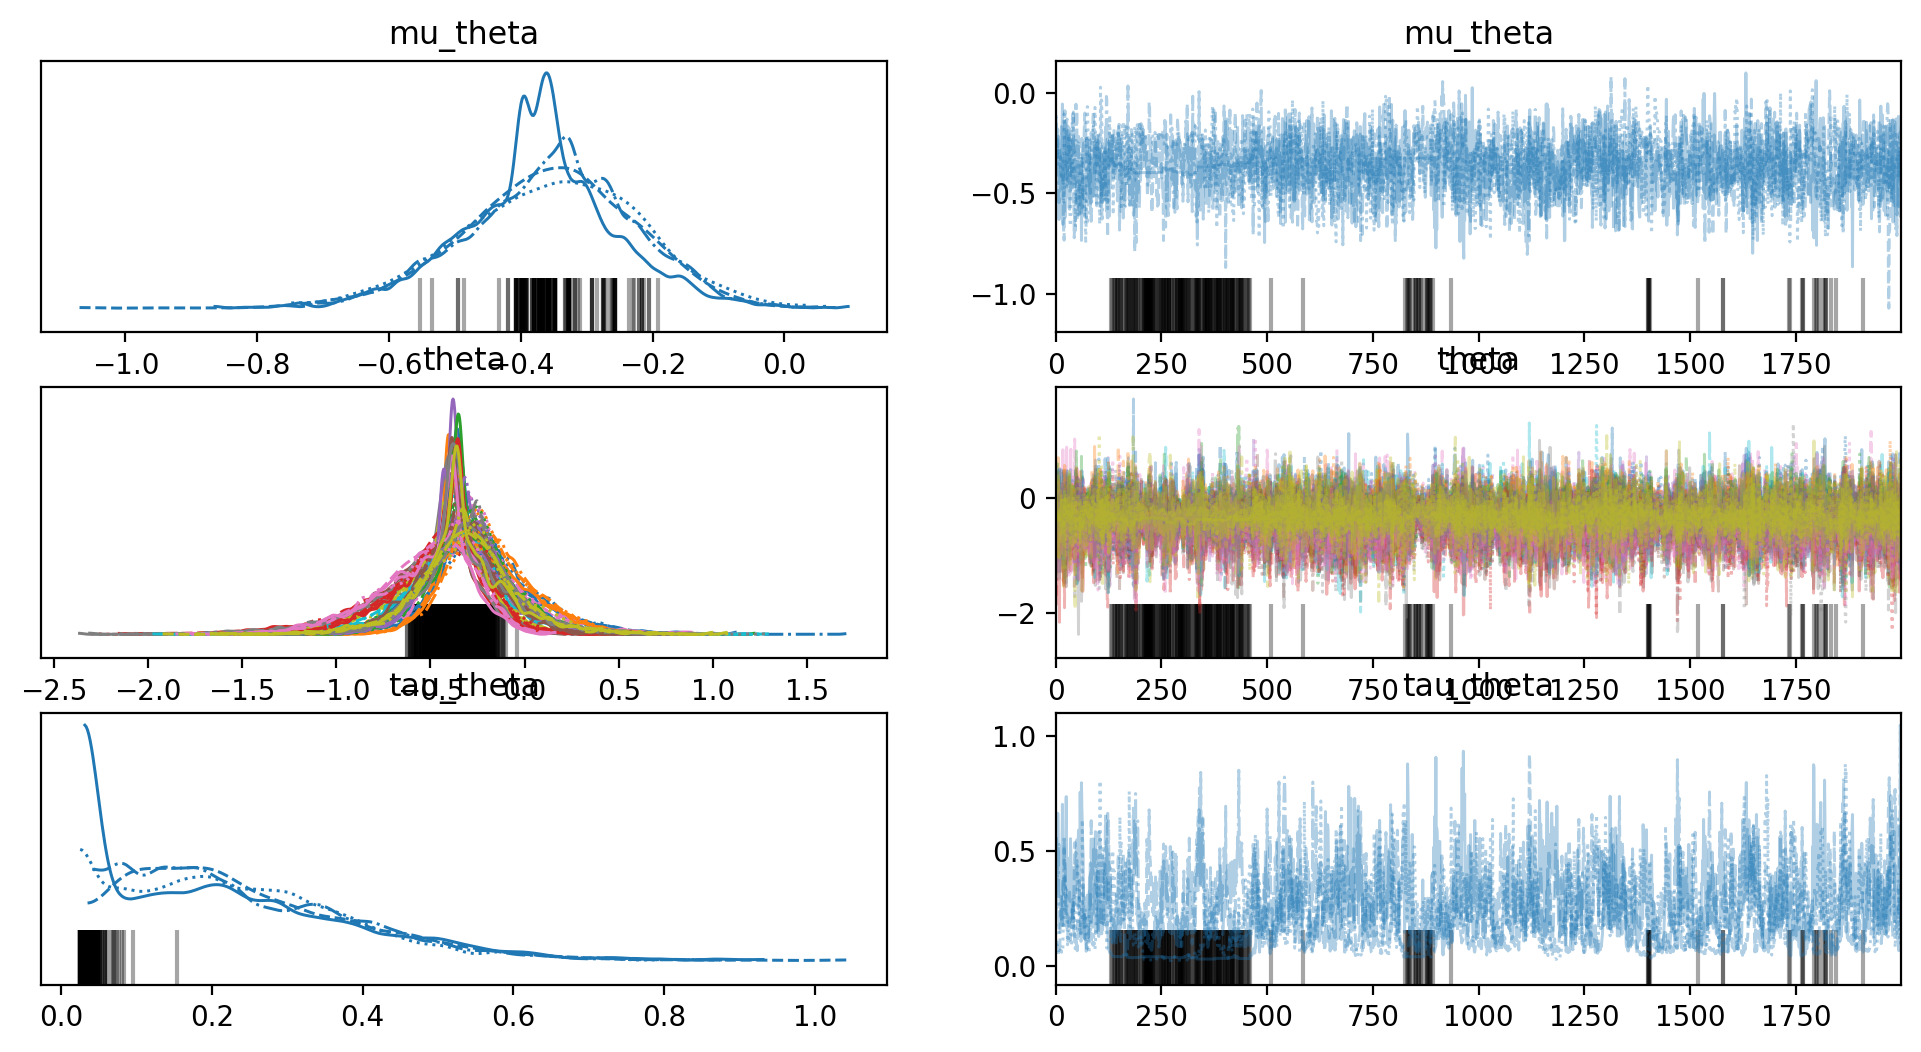

In [10]:
# Check the health of your MCMC chains
az.plot_trace(idata_normal);

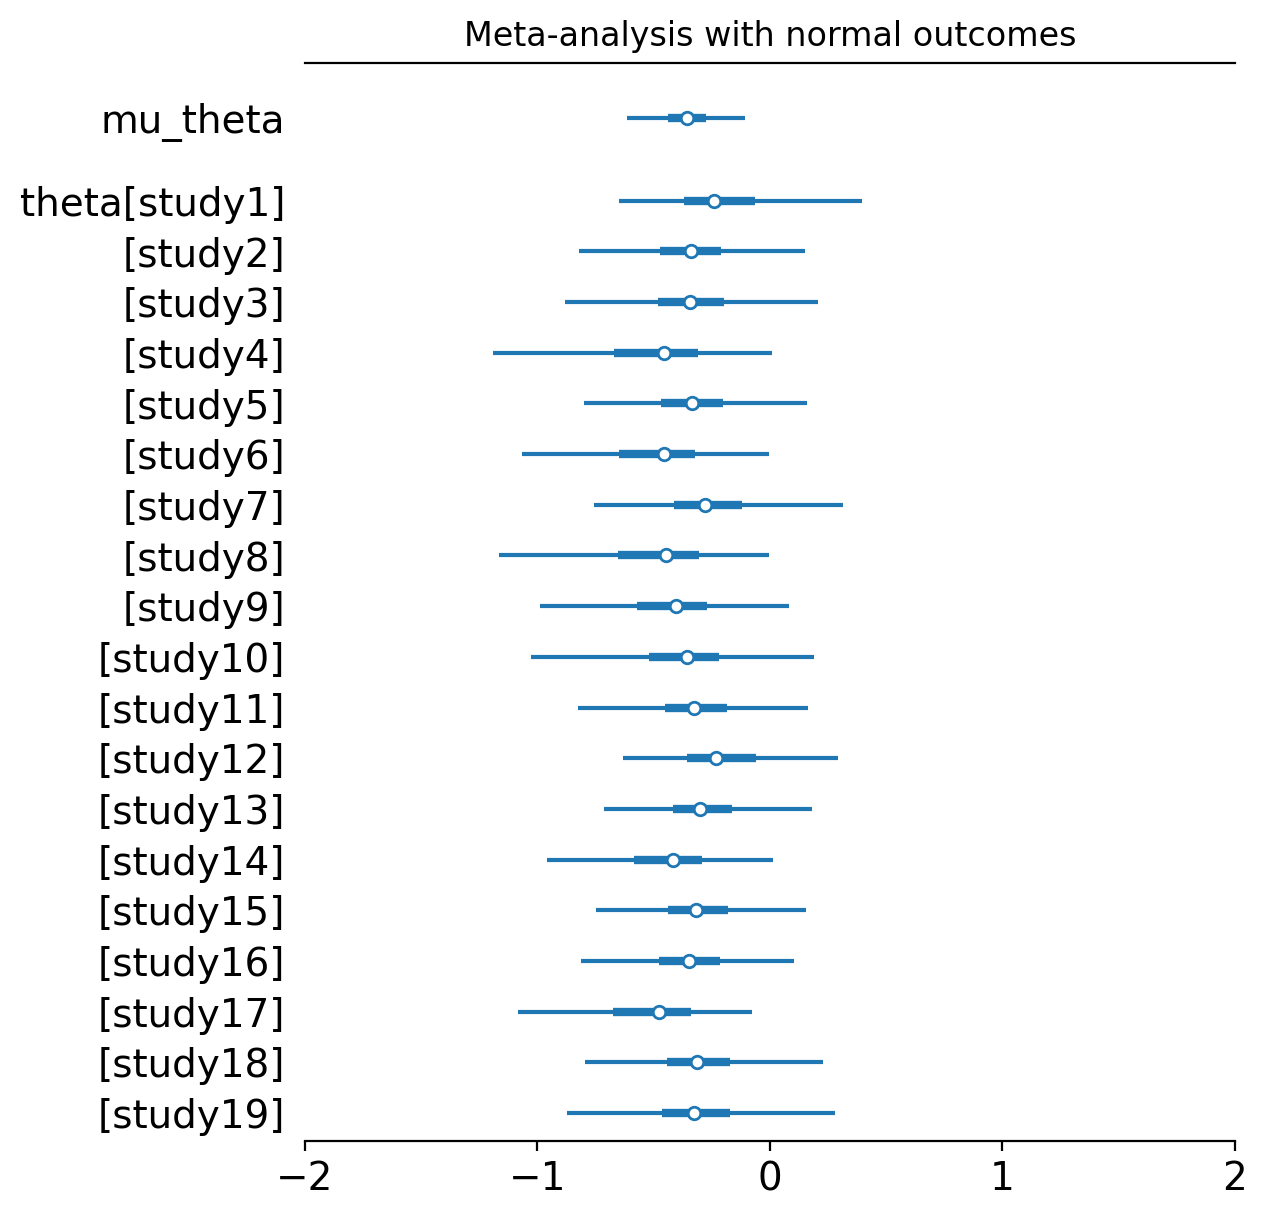

In [11]:
# Forest plot
_, ax = plt.subplots(figsize=(6, 7))
az.plot_forest(
    idata_normal,
    var_names=["mu_theta", "theta"],
    kind="forestplot",
    combined=True,
    ax=ax,
)
ax.set_xlim([-2, 2])
ax.set_title("Meta-analysis with normal outcomes");

In [12]:
# Plot parameter estimates in a table
az.summary(idata_normal, var_names=["mu_theta", "theta"])

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_theta,-0.359,0.128,-0.616,-0.109,0.004,0.003,1065.0,3250.0,1.02
theta[study1],-0.203,0.262,-0.648,0.394,0.007,0.005,1525.0,3220.0,1.00
theta[study2],-0.342,0.233,-0.823,0.150,0.003,0.003,3893.0,3814.0,1.01
theta[study3],-0.340,0.259,-0.883,0.207,0.004,0.003,3406.0,3582.0,1.01
theta[study4],-0.517,0.313,-1.193,0.010,0.010,0.007,897.0,2936.0,1.00
theta[study5],-0.333,0.234,-0.801,0.161,0.004,0.003,3863.0,4068.0,1.01
theta[study6],-0.501,0.270,-1.065,-0.004,0.009,0.007,784.0,3312.0,1.00
theta[study7],-0.252,0.264,-0.759,0.312,0.005,0.004,2347.0,3494.0,1.00
theta[study8],-0.506,0.302,-1.164,-0.003,0.009,0.006,1161.0,2662.0,1.01
theta[study9],-0.438,0.264,-0.989,0.080,0.006,0.005,1896.0,3105.0,1.00


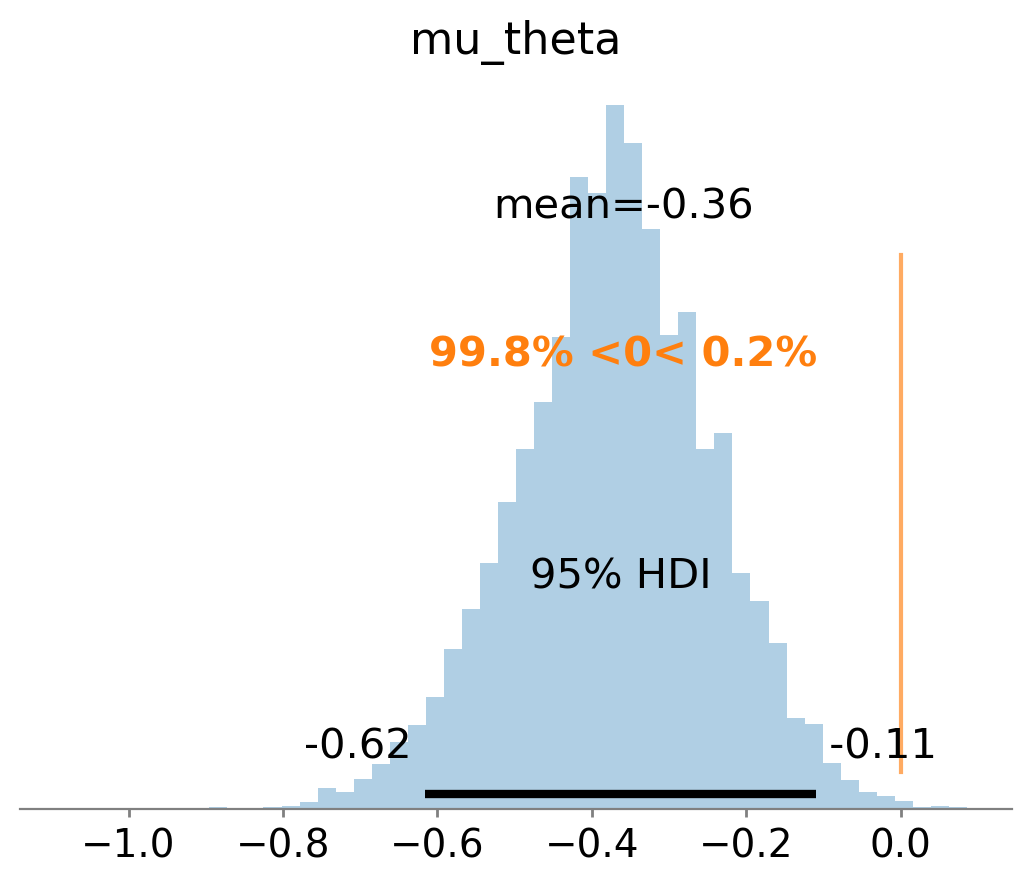

In [13]:
# Plot overall effect size
az.plot_posterior(idata_normal, var_names=["mu_theta"], kind="hist", bins=50, ref_val=0);